# PEMBELAJARAN MESIN

Tugas 1 - Clustering data (K-Means Method)

Fauzi Arya Surya Abadi | 1301194101 | IF-43-01

## Lib & Load Dataset 
Data set yang dugunakan file kendaraan_train.csv

In [3]:
#Library yang digunakan
from sklearn.preprocessing import MinMaxScaler
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np


#Read data from dataset
df_box = pd.read_csv('kendaraan_train.csv')
df_box.sample(5)

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
227132,227133,Wanita,24.0,1.0,28.0,1.0,< 1 Tahun,Tidak,50942.0,152.0,178.0,0
133343,133344,Pria,42.0,1.0,50.0,1.0,1-2 Tahun,Tidak,35063.0,8.0,63.0,0
144522,144523,Wanita,27.0,1.0,NaN,0.0,< 1 Tahun,Pernah,42239.0,152.0,85.0,0
217188,217189,Wanita,23.0,1.0,25.0,1.0,< 1 Tahun,Tidak,27040.0,26.0,251.0,0
273804,273805,Pria,23.0,1.0,28.0,0.0,< 1 Tahun,Pernah,53857.0,124.0,293.0,1


## Cleaning data kosong/NaN, ordinal, dan berkatagori
Pada tugas 1 clustering ini saya hanya menggunakan data yang bertipe numerik.

In [4]:
df_na_removed = df_box.dropna(how="any")
df_ornkat_removed = df_na_removed.drop(axis=1,
                    columns=["Jenis_Kelamin",
                             "Umur",
                             "SIM",
                             "Sudah_Asuransi",
                             "Kode_Daerah", 
                             "Umur_Kendaraan", 
                             "Kendaraan_Rusak"]) 
df_ornkat_removed.sample(8)

,id,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
130822,130823,39659.0,124.0,250.0,1
103987,103988,44886.0,26.0,215.0,1
177015,177016,41423.0,152.0,31.0,0
243300,243301,37326.0,124.0,214.0,0
205145,205146,2630.0,154.0,76.0,1
69583,69584,30610.0,152.0,223.0,0
17914,17915,38425.0,152.0,195.0,0
115451,115452,23966.0,160.0,259.0,0


In [5]:
# Mengecek data yang kosong setlah cleaning
df_ornkat_removed.isna().sum()

id                   0
Premi                0
Kanal_Penjualan      0
Lama_Berlangganan    0
Tertarik             0
dtype: int64

In [6]:
print("Setelah cleaning:",len(df_na_removed))

Setelah cleaning: 171068


Deteksi adanya outlier pada atribut **Premi, Kanal_Penjualan, Lama_Berlangganan, Tertarik**

Text(0, 0.5, 'Tertarik')

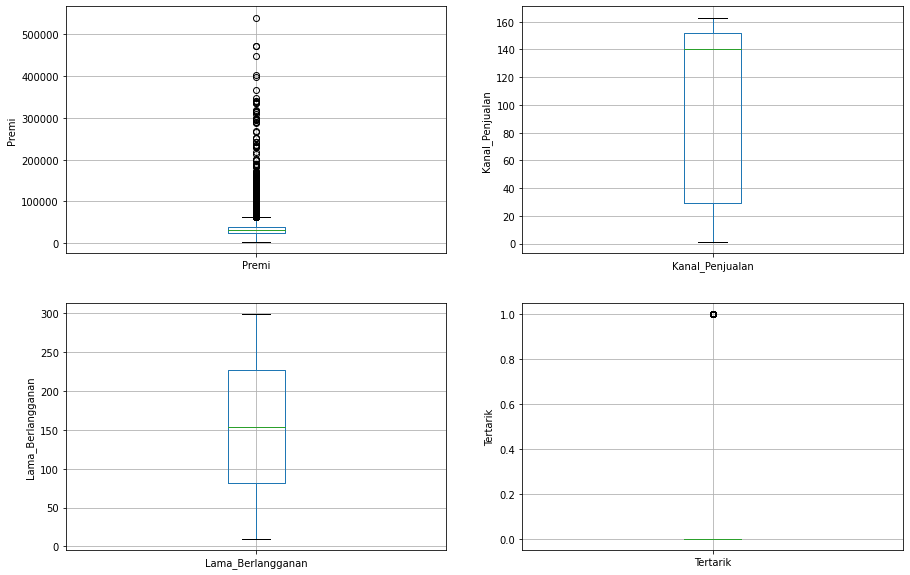

In [7]:
plt.figure(figsize=(15,10))
#Premi
plt.subplot(2, 2, 1); fig = df_ornkat_removed.boxplot(column='Premi')
fig.set_title(''); fig.set_ylabel('Premi')
#Kanal_Penjualan
plt.subplot(2, 2, 2); fig = df_ornkat_removed.boxplot(column='Kanal_Penjualan')
fig.set_title(''); fig.set_ylabel('Kanal_Penjualan')
#Lama_Berlangganan
plt.subplot(2, 2, 3); fig = df_ornkat_removed.boxplot(column='Lama_Berlangganan')
fig.set_title(''); fig.set_ylabel('Lama_Berlangganan')
#Tertarik
plt.subplot(2, 2, 4); fig = df_ornkat_removed.boxplot(column='Tertarik')
fig.set_title(''); fig.set_ylabel('Tertarik')

Dari diagram boxplot diatas terlihat bahwa atribut **Premi** mempunyai outlier.

In [8]:
num_outliers = ['Premi']
for feature in num_outliers:
    #Interquartile Range(IQR) = Q3-Q1
    IQR = df_ornkat_removed[feature].quantile(0.75) - df_ornkat_removed[feature].quantile(0.25)
    #Lower Fence = Q1-1.5(IQR)
    Lower_fence = df_ornkat_removed[feature].quantile(0.25) - (IQR * 3)
    #Upper Fence = Q3+1.5(IQR)
    Upper_fence = df_ornkat_removed[feature].quantile(0.75) + (IQR * 3)
    print('Nilai outliers dalam atribut {column} adalah < {lowerboundary} or > {upperboundary}'.format(column=feature, lowerboundary=Lower_fence, upperboundary=Upper_fence))

Nilai outliers dalam atribut Premi adalah < -20490.75 or > 84183.75


Nilai diatas merupakan nilai Upper dan Lower Outer Fence dari atribut **Premi** yang mempunyai Outliers

source: https://www.purplemath.com/modules/boxwhisk3.htm

### Mengatasi Outliers
> Mengatasi dengan mengganti nilai outliers dengan nilai ***Upper Outer Fence*** dari atribut yanng bersangkutan.

In [9]:
def max_value(df_handle, variable, top):
    return np.where(df_handle[variable]>top, top, df_handle[variable])
df_ornkat_removed['Premi'] = max_value(df_ornkat_removed, 'Premi', 84183.75) #84183.75 adalah nilai Upper fence dari atribut Premi
show = df_ornkat_removed.describe(); show

,id,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
count,171068.000000,171068.000000,171068.000000,171068.000000,171068.000000
mean,142794.020729,30372.857032,112.260206,154.253063,0.121577
std,82491.716355,16138.372697,54.106712,83.862579,0.326798
min,1.000000,2630.000000,1.000000,10.000000,0.000000
25%,71350.750000,24369.750000,29.000000,81.000000,0.000000
50%,142768.000000,31603.000000,140.000000,154.000000,0.000000
75%,214070.250000,39323.250000,152.000000,227.000000,0.000000
max,285831.000000,84183.750000,163.000000,299.000000,1.000000


In [10]:
df_ornkat_removed[0:1]

,id,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,28029.0,152.0,97.0,0


### Data Normalizations
>Pada tahap normalisasi ini menggunakan *MinMaxScaler()*

In [11]:
scaler = MinMaxScaler()
df_scaler = df_ornkat_removed.select_dtypes(include=[np.number]).copy()
df_scaler.drop('id',axis=1, inplace=True)
df_scaler.head()

,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,28029.0,152.0,97.0,0
1,25800.0,29.0,158.0,0
3,2630.0,124.0,63.0,0
5,22735.0,152.0,171.0,0
8,30786.0,160.0,31.0,0


In [12]:
column = df_scaler.columns; column

Index(['Premi', 'Kanal_Penjualan', 'Lama_Berlangganan', 'Tertarik'], dtype='object')

In [13]:
df_scaler = scaler.fit_transform(df_scaler)
df_scaler = pd.DataFrame(df_scaler, columns = column)
df_scaler.describe()

,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
count,171068.000000,171068.000000,171068.000000,171068.000000
mean,0.340179,0.686791,0.499146,0.121577
std,0.197886,0.333992,0.290182,0.326798
min,0.000000,0.000000,0.000000,0.000000
25%,0.266570,0.172840,0.245675,0.000000
50%,0.355263,0.858025,0.498270,0.000000
75%,0.449927,0.932099,0.750865,0.000000
max,1.000000,1.000000,1.000000,1.000000


Data dari masing-masing atribut telah ternomalisasi

In [14]:
df_scaler.reset_index(inplace=True)
df_scaler.rename(columns={'index':'id'}, inplace=True)
df_scaler.head(10)

,id,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.311439,0.932099,0.301038,0.0
1,1,0.284107,0.172840,0.512111,0.0
2,2,0.000000,0.759259,0.183391,0.0
3,3,0.246525,0.932099,0.557093,0.0
4,4,0.345245,0.981481,0.072664,0.0
5,5,0.387254,0.932099,0.941176,0.0
6,6,0.441255,0.888889,0.937716,0.0
7,7,0.000000,0.932099,0.422145,0.0
8,8,0.302316,0.932099,0.709343,0.0
9,9,0.437245,0.932099,0.743945,0.0


## Clustering

### Perhitungan Jarak
>Perhitungan jarak titik menggunakan *Euclidean Distance*

In [15]:
def euclidean(centroid, data):
    return sqrt(sum(pow(a-b,2) for a,b in zip(centroid, data)))

### K-Means Algorithm


In [16]:
def kmeans(data, k_clusters):
    # Menentukan posisi Centroid
    rng = np.random.RandomState(2); i = rng.permutation(data.shape[0])[:k_clusters]
    centroid = data.iloc[i, 1:].to_numpy(); result = pd.DataFrame(data['id'])
    arr_data = data.iloc[:, 1:].to_numpy()
    
    while True:
        cluster = []
        dict_id = {'Cluster {x}'.format(x=i+1) : [] for i in range(len(centroid))}
        dict_jarak = {'Centroid {x}'.format(x=i+1) : [] for i in range(len(centroid))}

        # Menghitung Jarak dterhdap setiap nilai
        progress = tqdm(range(len(arr_data)), leave=False)
        for index in progress:
            for i in range(len(centroid)):
                dict_jarak['Centroid {x}'.format(x=i+1)].append(euclidean(centroid[i] , arr_data[index]))
        
            # Ploting Cluster
            klaster = min(dict_jarak['Centroid {x}'.format(x=i+1)][index] for i in range(len(centroid)))
            for i in range(len(centroid)): 
                if klaster == dict_jarak['Centroid {x}'.format(x=i+1)][index]:
                    cluster.append('Cluster {x}'.format(x=i+1))
                    dict_id['Cluster {x}'.format(x=i+1)].append(index)
                    break                    
        
        result['Cluster'] = cluster
        
        # Menghitung Centroid baru
        new_centroid = []
        for i in range(len(centroid)):
            temp_centroid = []
            for column in data.iloc[:, 1:].columns:
                temp_centroid.append(data.loc[dict_id['Cluster {x}'.format(x=i+1)], column].mean())
            new_centroid.append(temp_centroid)
        new_centroid = np.array(new_centroid)
        
        if np.all(centroid == new_centroid):
            break
        centroid = new_centroid

    return result, centroid, dict_jarak

### Menggunakan Algoritma K-Means terhadap data
> Dari data yang diuji menggunakan atribut *'Premi'* dan *'Lama_Berlangganan'* dengan K=3.

In [17]:
result, centroid, dict_jarak = kmeans(df_scaler.loc[:, ['id', 'Premi', 'Lama_Berlangganan']], 3)
result.head()

,id,Cluster
0,0,Cluster 3
1,1,Cluster 1
2,2,Cluster 3
3,3,Cluster 2
4,4,Cluster 3


### Evaluasi CLustering
Menentukan nilai SSE (Sum of Squared Errors) 

In [18]:
jumlah = 0
for keys in dict_jarak.keys():
    result[keys] = dict_jarak[keys]    
for k in range(len(result['Cluster'].unique())):
    jumlah += sum(pow(i, 2) for i in result[result['Cluster'] == 'Cluster {x}'.format(x=k+1)]['Centroid {x}'.format(x=k+1)])
print('Nilai SSE pada K=3 : {x}'.format(x=jumlah))

Nilai SSE pada K=3 : 7848.957457480767


## Visualitation

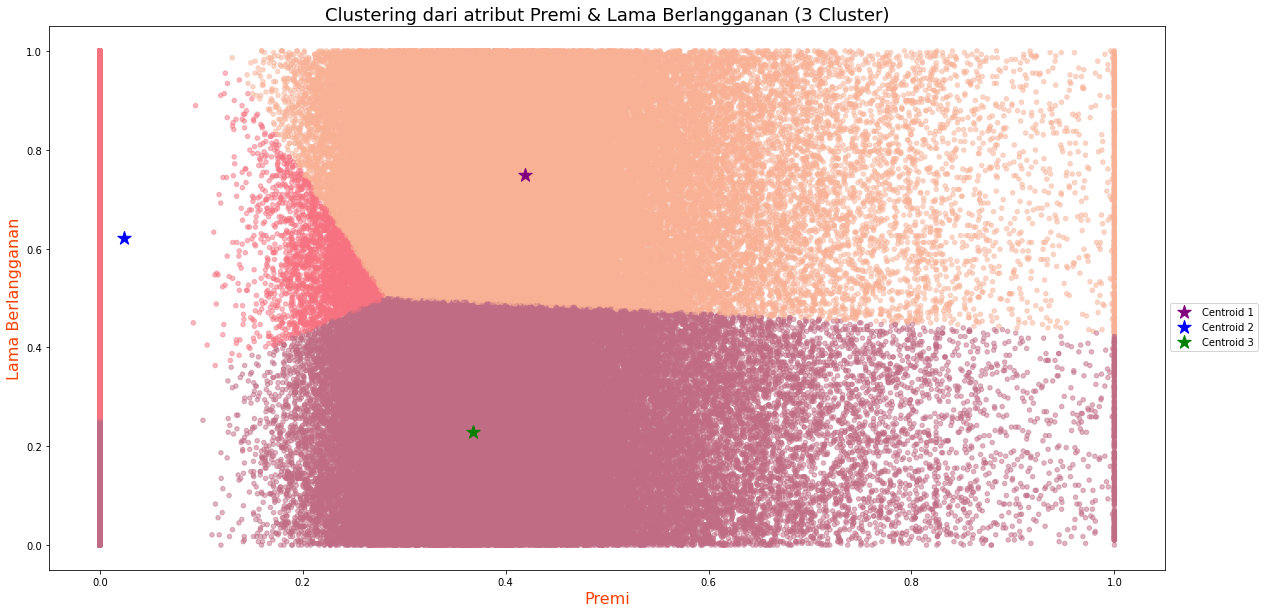

In [19]:
colors = ['#F8B195', '#F67280', '#C06C84']
result['c'] = result.Cluster.map({'Cluster 1':colors[0], 'Cluster 2':colors[1], 'Cluster 3':colors[2]})
e1 = df_scaler.plot(kind='scatter', x='Premi', y='Lama_Berlangganan', figsize=(20, 10), alpha=0.5, color=result.c)

cen_x = [i[0] for i in centroid] 
cen_y = [i[1] for i in centroid]
ax1 = plt.scatter(cen_x[0], cen_y[0], c='purple', s=200, label='Centroid 1', marker='*')
ax2 = plt.scatter(cen_x[1], cen_y[1], c='blue', s=200, label='Centroid 2', marker='*')
ax2 = plt.scatter(cen_x[2], cen_y[2], c='green', s=200, label='Centroid 3', marker='*')

e1.set_xlabel('Premi', fontsize=16, color="#F94001")
e1.set_ylabel('Lama Berlangganan', fontsize=16, color="#F94001")
e1.set_title('Clustering dari atribut Premi & Lama Berlangganan (3 Cluster)', fontsize=18)
e1.legend(loc='best', bbox_to_anchor=(1,0.5))

### Elbow Method

Evaluasi Clustering menggunakan Elbow Method dan mencari K yang paling optimal. Pengujian menggunakan k=3 sampai k=10 dengan atribut yang digunakan Premi dan Lama_Berlangganan. Tetapi saya menggunakan library KMeans sklearn.cluster untuk kompleksitas algoritma Kmeans yang terbaik.

source : https://skillplus.web.id/elbow-method/

In [20]:
df = df_scaler[['Premi', 'Lama_Berlangganan']]
df.head()

,Premi,Lama_Berlangganan
0,0.311439,0.301038
1,0.284107,0.512111
2,0.000000,0.183391
3,0.246525,0.557093
4,0.345245,0.072664


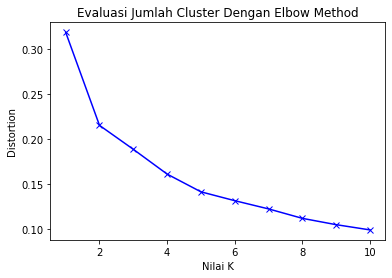

In [27]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

K = range(1,11)

for i in K:
    model = KMeans(n_clusters=i).fit(df)
    model.fit(df)
    distortions.append(sum(np.min(cdist(df, model.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])
   
plt.plot(K, distortions, 'bx-')
plt.xlabel('Nilai K')
plt.ylabel('Distortion')
plt.title('Evaluasi Jumlah Cluster Dengan Elbow Method')
plt.show()

Dalam plot diatas k=5 menunjukkan k paling optimal untuk dataset ini

### Silhouette Method
Analisa untuk mencari nilai cluster yang terbaik selanjutnya saya menggunakan *Silhouette* method. untuk range pengujian dilakukan dalam K range 2 sampai 4. dikarenakan metode ini membutuhkan waktu cukup lama untuk mengeksekusi per cluster nya.

source: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

Cluster = 2 Nilai rata-rata Silhouette : 0.44742180051273184
Cluster = 3 Nilai rata-rata Silhouette : 0.43184243938183337
Cluster = 4 Nilai rata-rata Silhouette : 0.38695587740967596


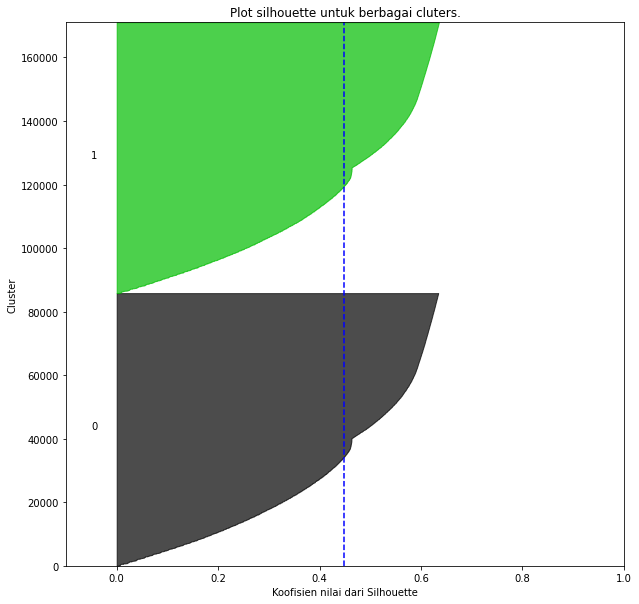

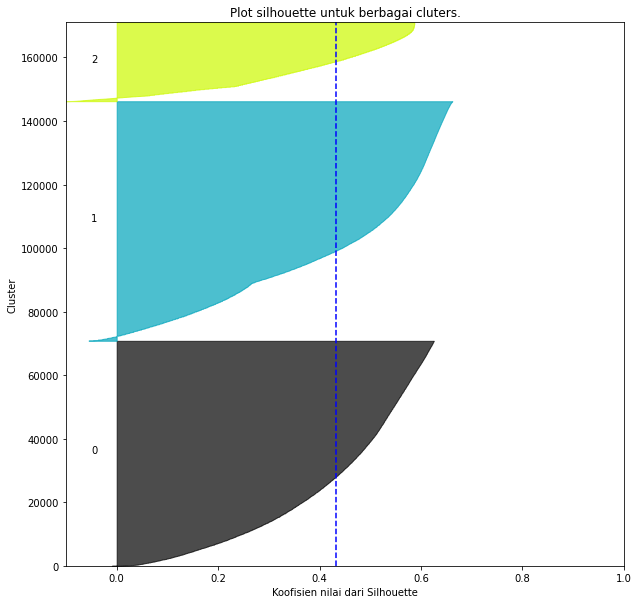

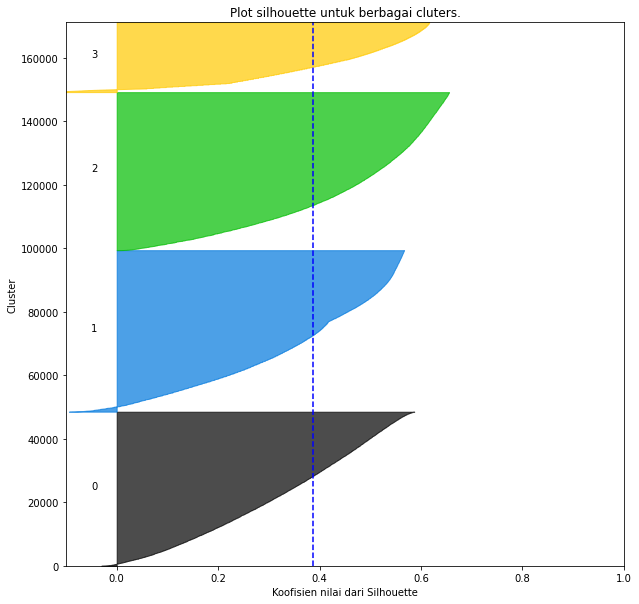

In [60]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # membuat subplot dengan 1 baris & 1 kolom
    fig, ax1 = plt.subplots(1, 1) 
    fig.set_size_inches(10, 10) 
    #Set nilai batas koofisien Silhoueete
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])

    # Inisialisasi clusterer dengan nilai n_cluster dan dataframe yang sudah ternomalisasi
    clusterer = KMeans(n_clusters=n_clusters).fit(df)
    cluster_labels = clusterer.fit_predict(df)
    # Silhouette_score memberikan nilai rata-rata untuk semua sampel
    silhouette_avg = silhouette_score(df, cluster_labels)
    print("Cluster =",n_clusters, "Nilai rata-rata Silhouette :",silhouette_avg,)
    sample_silhouette_values = silhouette_samples(df, cluster_labels) #Hitung skor Silhououtte

    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Plot silhouette untuk berbagai cluters.")
    ax1.set_xlabel("Koofisien nilai dari Silhouette")
    ax1.set_ylabel("Cluster")
    ax1.axvline(x=silhouette_avg, color="blue", linestyle="--")
plt.show()